In [1]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 88.8MB 1.1MB/s 
     |████████████████████████████████| 3.8MB 39.3MB/s 
     |████████████████████████████████| 450kB 50.7MB/s 
     |████████████████████████████████| 71kB 40.2MB/s 
  Created wheel for opt-einsum: filename=opt_einsum-3.0.1-cp36-none-any.whl size=58500 sha256=cc64a534ee71ba91f066d5e6dea0735f72601b94f5a12a07c7c17927e77bc4e2
  Stored in directory: /root/.cache/pip/wheels/91/98/8d/10e3d4e04c959597a411b91acd3695e9e2d210e68ce3427aad
Successfully built opt-einsum


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20190825


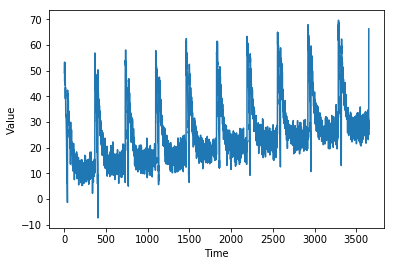

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 2.8

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),                       
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

W0826 04:41:49.356787 140488050362240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
94/94 [==============================] - 10s 102ms/step - loss: 22.0164 - mae: 22.3864
Epoch 2/100
94/94 [==============================] - 4s 38ms/step - loss: 21.8566 - mae: 22.3677
Epoch 3/100
94/94 [==============================] - 4s 37ms/step - loss: 21.8429 - mae: 22.3465
Epoch 4/100
94/94 [==============================] - 4s 38ms/step - loss: 21.8167 - mae: 22.3227
Epoch 5/100
94/94 [==============================] - 3s 37ms/step - loss: 21.7903 - mae: 22.2960
Epoch 6/100
94/94 [==============================] - 4s 37ms/step - loss: 21.7694 - mae: 22.2662
Epoch 7/100
94/94 [==============================] - 4s 38ms/step - loss: 21.7348 - mae: 22.2326
Epoch 8/100
94/94 [==============================] - 4s 38ms/step - loss: 21.7014 - mae: 22.1950
Epoch 9/100
94/94 [==============================] - 4s 39ms/step - loss: 21.6512 - mae: 22.1529
Epoch 10/100
94/94 [==============================] - 4s 38ms/step - loss: 21.6070 - mae: 22.1055
Epoch 11/100
94/94 [=======

[1e-08, 0.0001, 0, 30]

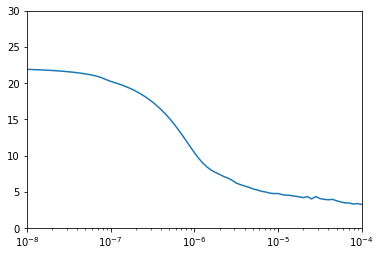

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 9s 100ms/step - loss: 75.4413 - mae: 6.0023
Epoch 2/500
94/94 [==============================] - 4s 38ms/step - loss: 43.5143 - mae: 4.4827
Epoch 3/500
94/94 [==============================] - 4s 38ms/step - loss: 28.9377 - mae: 3.5048
Epoch 4/500
94/94 [==============================] - 3s 37ms/step - loss: 26.4872 - mae: 3.3867
Epoch 5/500
94/94 [==============================] - 4s 37ms/step - loss: 28.5714 - mae: 3.6370
Epoch 6/500
94/94 [==============================] - 4s 38ms/step - loss: 26.3123 - mae: 3.4394
Epoch 7/500
94/94 [==============================] - 4s 39ms/step - loss: 24.3005 - mae: 3.2210
Epoch 8/500
94/94 [==============================] - 4s 37ms/step - loss: 28.4218 - mae: 3.6179
Epoch 9/500
94/94 [==============================] - 4s 37ms/step - loss: 24.7629 - mae: 3.2770
Epoch 10/500
94/94 [==============================] - 4s 38ms/step - loss: 25.0666 - mae: 3.3185
Epoch 11/500
94/94 [==================

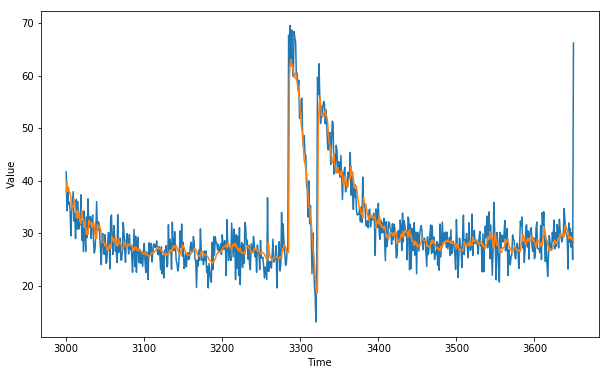

In [8]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.6641612

<Figure size 432x288 with 0 Axes>

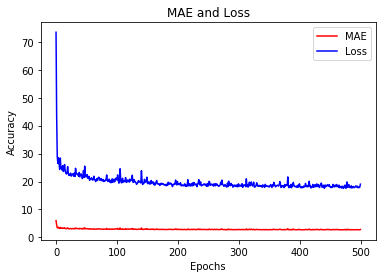

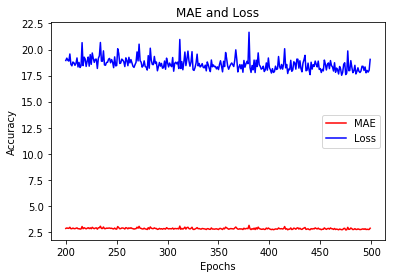

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()